STAT 451: Machine Learning (Fall 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat451-fs2020/

# 4) ROC

## Loading the Breast Cancer Wisconsin dataset

- In the Breast Cancer Wisconsin dataset, the firt column in this dataset stores the unique ID numbers of patients
- The second column stores the corresponding cancer diagnoses (M = malignant, B = benign)
- Columns 3-32 contain features that were extracted from digitized images of the nuclei of the cancer cells, which can be used to build a model to predict whether a tumor is benign or malignant.
- The Breast Cancer Wisconsin dataset has been deposited in the UCI Machine Learning Repository, and more detailed information about this dataset can be found at https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic).

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
df.shape

(569, 32)

<hr>

- First, we are converting the class labels from a string format into integers

In [3]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

- Here, class "M" (malignant cancer) will be converted to class 1, and "B" will be converted into class 0 (the order the class labels are mapped depends on the alphabetical order of the string labels)

In [4]:
le.transform(['M', 'B'])

array([1, 0])

- Next, we split the data into 80% training data and 20% test data, using a stratified split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

# 4) ROC

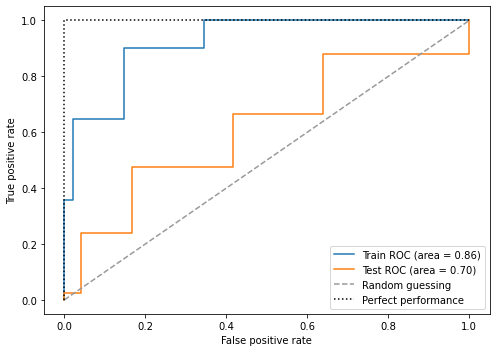

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
import numpy as np


# smaller training set to make the curve more interesting
X_train2 = X_train[:, [4, 14]]

pipe_knn = make_pipeline(StandardScaler(),
                         KNeighborsClassifier())


fig = plt.figure(figsize=(7, 5))


#############################################################
### TRAINING ROC CURVE
train_probas = pipe_knn.fit(X_train2,
                            y_train).predict_proba(X_train2)

fpr, tpr, thresholds = roc_curve(y_train,
                                 train_probas[:, 1],
                                 pos_label=1)
roc_auc = auc(fpr, tpr)

plt.step(fpr,
         tpr,
         label='Train ROC (area = %0.2f)'
               % (roc_auc))
#############################################################


#############################################################
### TEST ROC CURVE
test_probas = pipe_knn.predict_proba(X_test[:, [4, 14]])

fpr, tpr, thresholds = roc_curve(y_test,
                                 test_probas[:, 1],
                                 pos_label=1)
roc_auc = auc(fpr, tpr)

plt.step(fpr,
         tpr,
         where='post',
         label='Test ROC (area = %0.2f)'
               % (roc_auc))
#############################################################

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

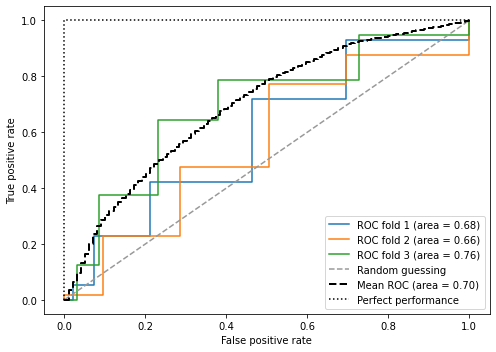

In [7]:
from sklearn.model_selection import StratifiedKFold


pipe_knn = make_pipeline(StandardScaler(),
                         KNeighborsClassifier())

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3, 
                          shuffle=True,
                          random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_knn.fit(X_train2[train],
                          y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.step(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc), where='post')

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.step(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2, where='post')
plt.step([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance', where='post')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()